In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [62]:
from IPython.display import Image, Video

import pickle
import numpy as np
import pandas as pd

import nilearn as nil
from nilearn.plotting import plot_glass_brain
from nilearn import plotting

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_context("talk")
%matplotlib inline

%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2020-10-20T22:59:14-04:00

CPython 3.6.9
IPython 7.16.1

compiler   : GCC 8.4.0
system     : Linux
release    : 4.15.0-1093-oem
machine    : x86_64
processor  : x86_64
CPU cores  : 20
interpreter: 64bit


In [63]:
%%bash
echo "Current branch"
git branch

Current branch
  explore_appr_retr
* master
  refactor_appr_retr


# Introduction

## What is fMRI data?

- Functional Magnetic Resonance Imaging (fMRI).
- Timeseries data.
- Like a movie of the brain.
- Each frame (timepoint) is a 3D volume.
- Rate at which fMRI data is collected is commonly referred to as repetition time (TR).
- Commonly used TR is 0.5-2 seconds per volume. TR = 1.25 seconds for the current study.

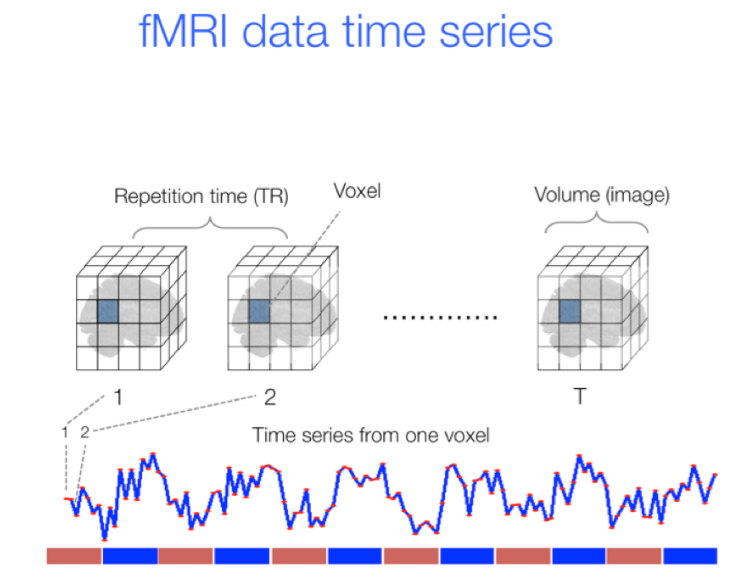

## Typical fMRI setup
- Participants view visual stimuli on a projection screen via a mirror mounted to the scanner's head coil.  
- Head coil measures the brain signal.  

<img src="support/images/scanner.jpg" alt="scanner" class="bg-primary" width="300"> <img src="support/images/head_coil.jpg" alt="headcoil" class="bg-primary"> <img src="support/images/projection_screen.jpeg" alt="screen" class="bg-primary" width="400">

# Methods

## Procedure & Visual Stimuli
- fMRI data was collected on 61 participants.
- Forty-five minutes of fMRI data was collected on every participant.
- Two circles moved around on the screen randomly. 
- When circles collided, an unpleasant mild electric shock was delivered to the index and middle fingers of participant's left hand. 
- Shock delivery was only meant to induce fear of circle collision.
- Several events of "near-miss" occured at random times during the experiment. 
- "Near-miss" events are defined as those when the circles approach each other for at least 8 seconds, come very close (i.e., distance less than 1.5 times the circle diameter), but miss and start to retreat, again, at least for 8 seconds.
- "Near-miss" events were included to investigate the brain's dynamic response to approaching and retreating threats.

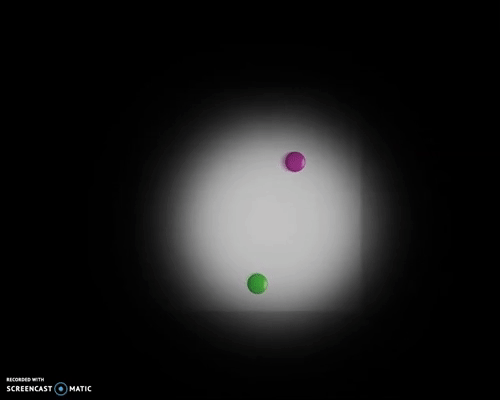


### Preprocessing
- fMRI timeseries data suffers from a lot of noise such as,
    - Physiological signals associated with respiratory and cardiac cycles.
    - Head motion.
    - Scanner noise (drifts).
- These noise were filtered out using ICA (https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/).

## Training Data

- Out of the 45 minute long timeseries data, segments corresponding to near-miss events were extracted.
- Each segment was 14 timepoints long (14 x 1.25 = 8.75 seconds): first 7 timepoints corresponded to **approach**, and later 7 to **retreat**. 
- Every participant had 46 segments. That is, ~13 minutes out 45 minutes of data was used for training.
- Following is an example of a segment from the parietal cortex of the brain.

/home/climbach/approach-retreat/tensorflow/local/lib/python3.6/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



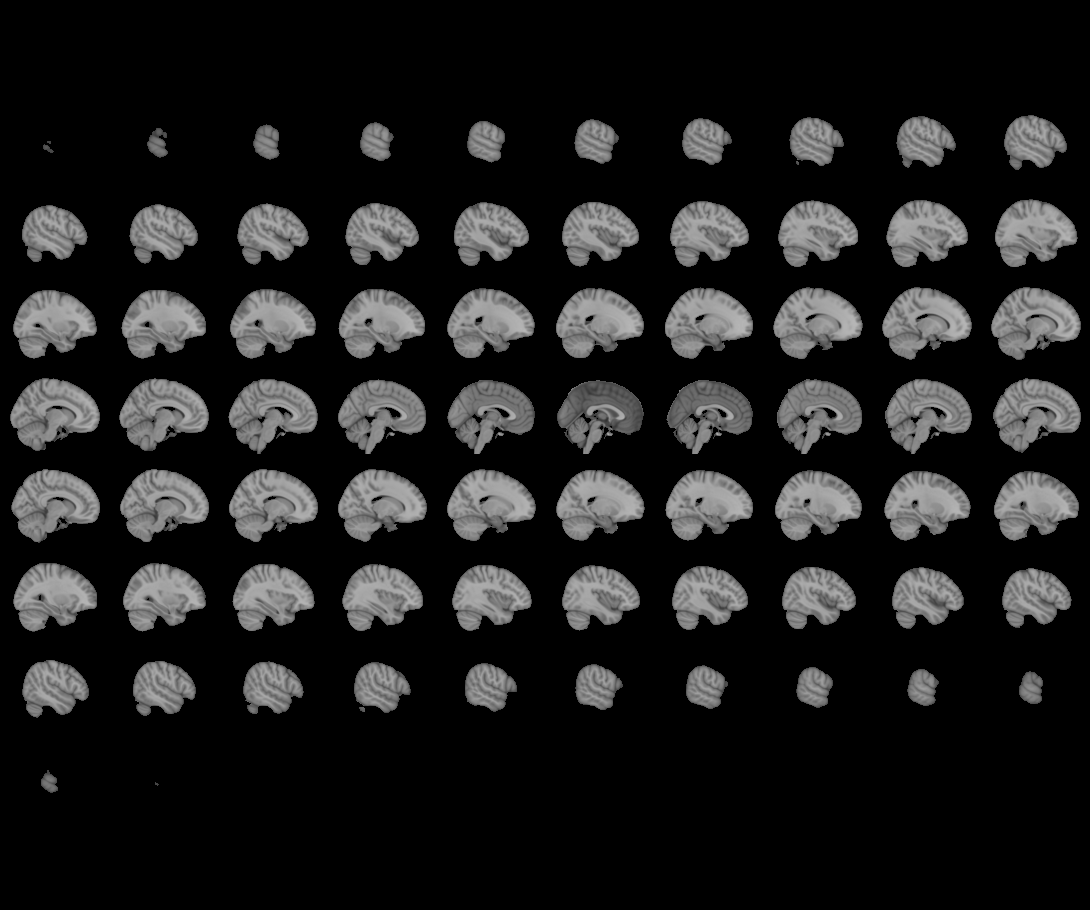
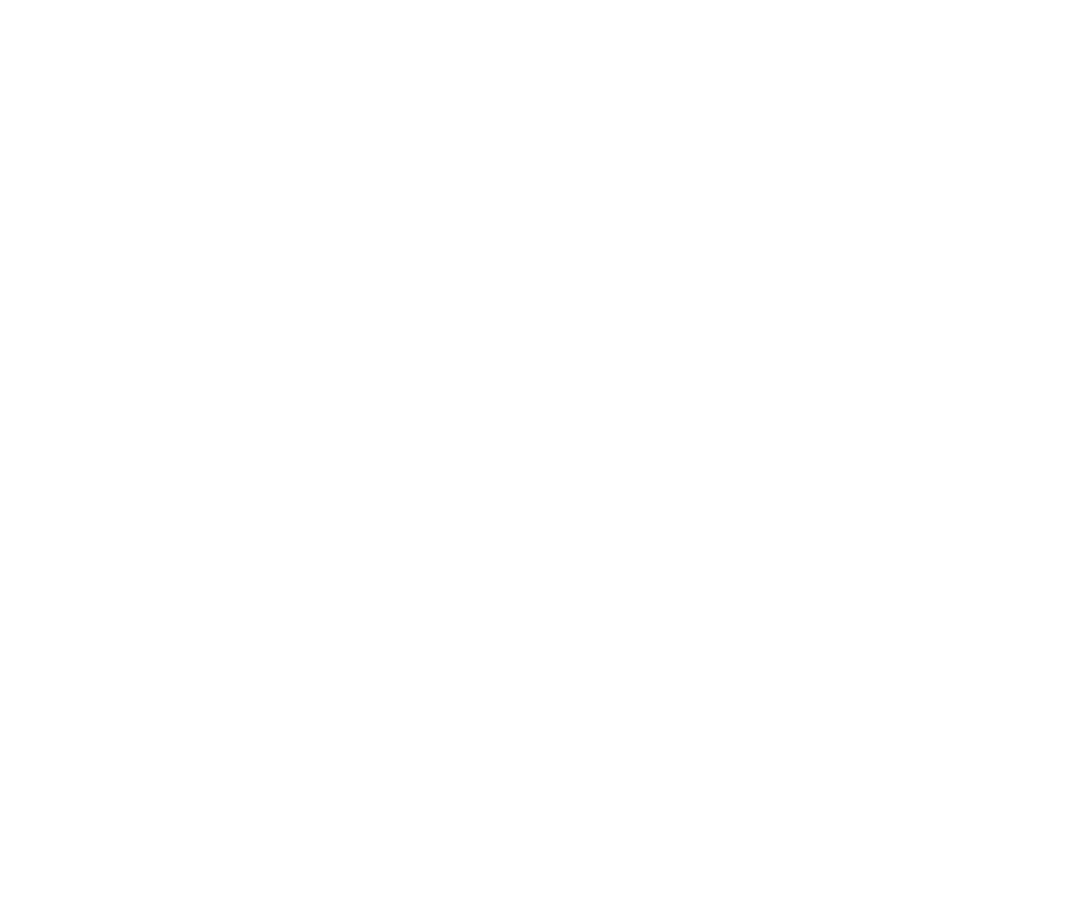

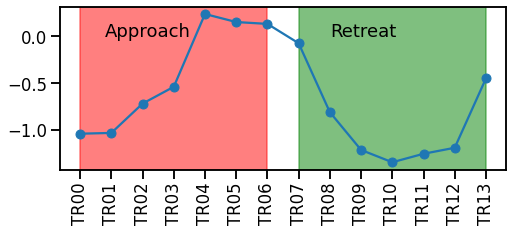

In [64]:
## Load the data
with open("data/processed/00a-ROI316_withShiftedSegments.pkl","rb") as f:
    dataset=pickle.load(f)
        
roi_idx = 108
roi = np.squeeze(dataset['CON054']['data'][:,[roi_idx],0:36:6])
plt.figure(figsize=(8,3))
plt.plot(np.arange(14)*1.25,roi[:,0],marker='o')
plt.axvspan(0,7.5,color='red',alpha=0.5)
plt.axvspan(8.75,16.25,color='green',alpha=0.5)
plt.text(1,0,'Approach',fontdict={'size':18})
plt.text(10,0,'Retreat',fontdict={'size':18})
_=plt.xticks(np.arange(14)*1.25, labels=['TR{:02d}'.format(tr) for tr in np.arange(14)],rotation=90)

mask = nil.image.load_img("data/processed/masks/00b-Schaefer2018_300Parcels_17Networks_order_afniMNI152_2mm_GM.nii.gz")
roi_mask = np.zeros_like(mask.get_fdata())
roi_mask[mask.get_fdata() == roi_idx] = 1.
roi_mask = nil.image.new_img_like(mask, roi_mask)
#plot_glass_brain(roi_mask)
plotting.view_img(roi_mask,symmetric_cmap=False,vmax=1)

- Training segments from a total of 316 brain regions were extracted in a similar fashion.
- Following figure shows all the brain regions. 

/home/climbach/approach-retreat/tensorflow/local/lib/python3.6/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



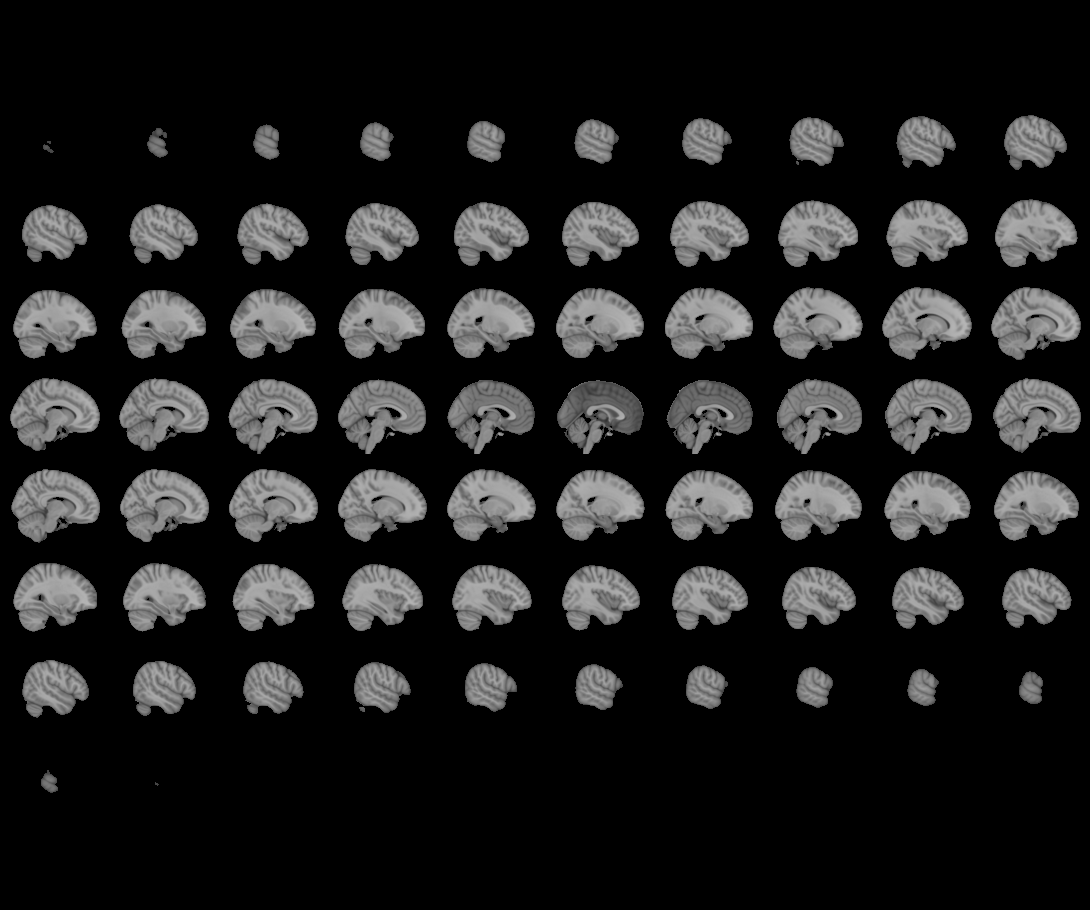
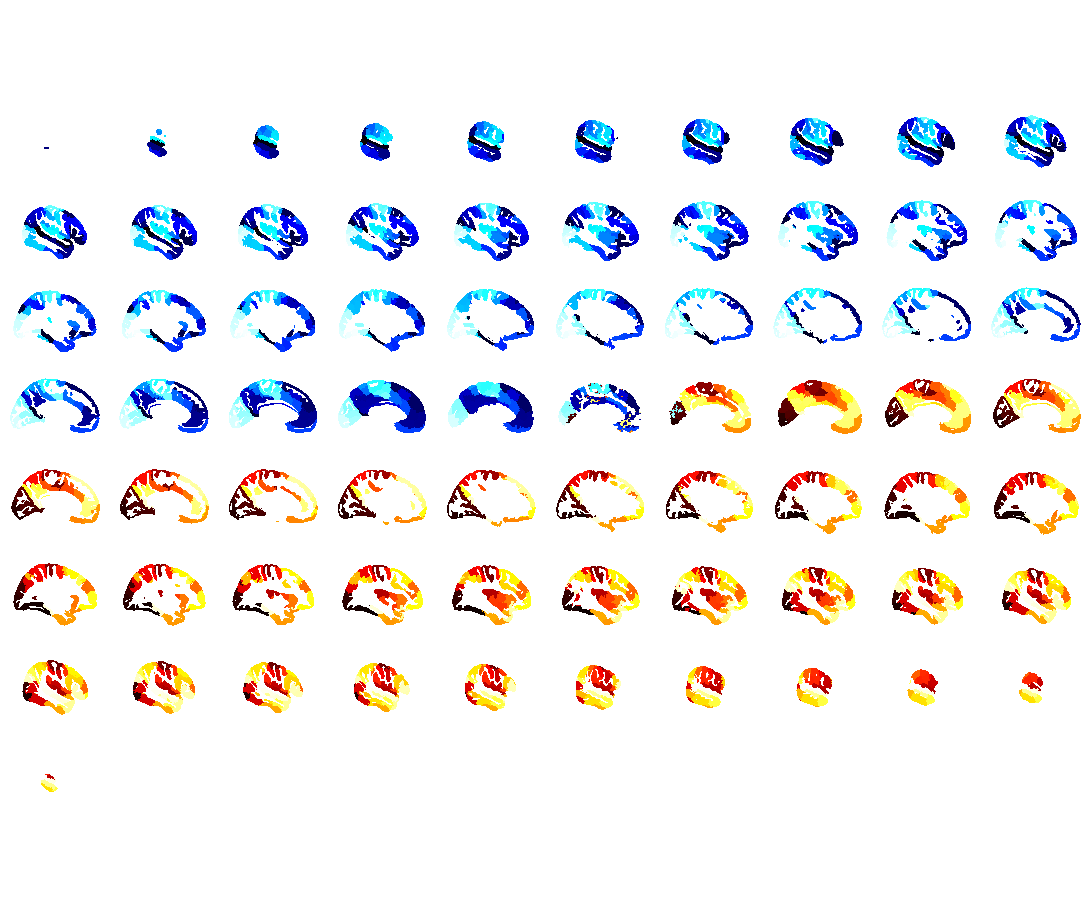

In [65]:
plotting.view_img(mask,symmetric_cmap=False,vmax=300)

- The segment was divided into two training examples and labeled accordingly as follows:

                             <----------- Timeseries --------------->       Label  
        training example 1: [TR00, TR01, TR02, TR03, TR04, TR05, TR06] -> "approach"  
        training example 2: [TR07, TR08, TR09, TR10, TR11, TR12, TR13] -> "retreat"  
        
        
        
- Problem with this kind of training segments is that the trained model will not make an accurate prediction unless the cricles have already been aproaching (or retreating) for at least 8 seconds.  
- To make the model more robust to change in the direction of the circles (from approach to retreat and vise-versa), five more timepoints from past were included for every training segment while keeping the effective length of the segment consistent. For example, the `training exmaple 1`
shown above was extended as follows:

                                <-------------------------------  Time  ------------------------------------->
           training example 1:                                  [TR00, TR01, TR02, TR03, TR04, TR05, TR06] -> "approach"  
                                                         [-TR01, TR00, TR01, TR02, TR03, TR04, TR05]       -> "approach"
                                                  [-TR02, -TR01, TR00, TR01, TR02, TR03, TR04]             -> "approach"
                                           [-TR03, -TR02, -TR01, TR00, TR01, TR02, TR03]                   -> "approach"
                                    [-TR04, -TR03, -TR02, -TR01, TR00, TR01, TR02]                         -> "approach"
                             [-TR05, -TR04, -TR03, -TR02, -TR01, TR00, TR01]                               -> "approach" 
                             
                             
- Retreat segments were extended in the same fashion. Following shows the original segments and their extensions.

In [66]:
approach, retreat = [], []
for i in range(roi.shape[1]):
    if i == 0:
        name = "pure"
    else:
        name = "pure - %i TRs" %(i)
    approach.append(pd.Series(roi[:7,i],index=np.arange(7)-i,name=name))
    retreat.append(pd.Series(roi[7:,i],index=np.arange(7,14)-i,name=name))

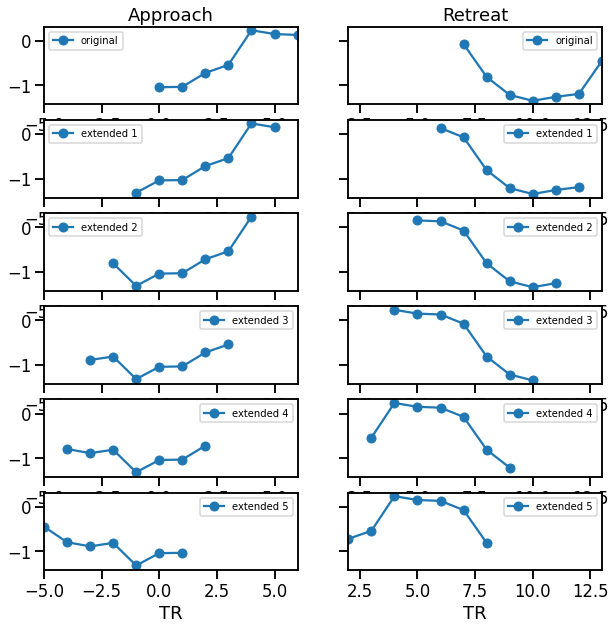

In [68]:
fig, axes = plt.subplots(nrows=6,ncols=2,figsize=(10,10),sharey=True)

for j, seg in enumerate([approach, retreat]):
    for i in range(6):
        if j == 0:
            title = 'Approach'
            xlim = (-5, 6)
        elif j == 1:
            title = 'Retreat'
            xlim = (2, 13)
            
        if i > 0:
            title = None
        
        xlab = 'TR'
        if i < 5:
            xlab = None
            
        if i == 0:
            label = 'original'
        else:
            label = 'extended {}'.format(i)
            
        axes[i,j].plot(seg[i].index,seg[i],marker='o',label=label)
        axes[i,j].set_xlim(xlim)
        axes[i,j].set_title(title)
        axes[i,j].set_xlabel(xlab)
        axes[i,j].legend(fontsize=10)